### Semplice rete neurale per MNIST da zero

Questa progetto mostra come costruire e addestrare una rete neurale semplice (1 hidden layer) per classificare le cifre MNIST, implementando tutto da zero in NumPy.

##### 1. Import delle librerie e caricamento dati
Importo le librerie fondamentali e carico il dataset MNIST per il training.

In [1]:
import numpy as np  # Calcolo numerico
import pandas as pd  # Gestione dati
from matplotlib import pyplot as plt  # Visualizzazione immagini

# Carica il dataset MNIST (train.csv: immagini + etichette)
data = pd.read_csv('train.csv')

##### 2. Preprocessing dei dati
Divido i dati in training/dev set, normalizzo i pixel e separo immagini e labels.

In [2]:
data = np.array(data)
m, n = data.shape  # m: numero esempi, n: 785 (784 pixel + 1 label)
np.random.shuffle(data)  # Mescola i dati per evitare bias

# Set di sviluppo (dev): primi 1000 esempi
data_dev = data[0:1000].T
Y_dev = data_dev[0]  # Etichette
X_dev = data_dev[1:n]  # Immagini
X_dev = X_dev / 255.  # Normalizza pixel in [0,1]

# Set di training: tutti gli altri
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.  # Normalizza pixel
_, m_train = X_train.shape  # m_train: numero esempi di training

In [3]:
Y_train

array([6, 1, 0, ..., 4, 0, 0], shape=(41000,))

##### 3. Definizione della rete neurale e funzioni di supporto
La rete neurale avrà un’architettura semplice a due layers. Il layer di input $a^{[0]}$ avrà 784 unità corrispondenti ai 784 pixel di ciascuna immagine di input 28x28. Un layer nascosto $a^{[1]}$ avrà 10 unità con attivazione ReLU, e infine il layer di output $a^{[2]}$ avrà 10 unità corrispondenti alle dieci classi di cifre con attivazione softmax.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [4]:
# Inizializza i pesi e bias per i due strati
def init_params():
    W1 = np.random.rand(10, 784) - 0.5  # Pesi hidden layer
    b1 = np.random.rand(10, 1) - 0.5    # Bias hidden layer
    W2 = np.random.rand(10, 10) - 0.5   # Pesi output layer
    b2 = np.random.rand(10, 1) - 0.5    # Bias output layer
    return W1, b1, W2, b2

# Funzione di attivazione ReLU
def ReLU(Z):
    return np.maximum(Z, 0)

# Funzione di attivazione softmax (output layer)
def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

# Forward propagation: calcola output e attivazioni
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

# Derivata della ReLU (per il backprop)
def ReLU_deriv(Z):
    return Z > 0

# Trasforma le etichette in vettori one-hot
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

# Backward propagation: calcola i gradienti
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

# Aggiorna i parametri usando il gradiente e il learning rate
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

##### 4. Funzioni di valutazione e training
Definisco le funzioni per calcolare predizioni, accuratezza e per eseguire il ciclo di training (gradient descent).

In [5]:
# Restituisce la classe con probabilità massima per ogni esempio
def get_predictions(A2):
    return np.argmax(A2, 0)

# Calcola l'accuratezza delle predizioni rispetto alle etichette reali
def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

# Ciclo di training: gradient descent
def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [6]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[8 8 8 ... 1 5 8] [6 1 0 ... 4 0 0]
0.1
Iteration:  10
[7 9 9 ... 7 3 3] [6 1 0 ... 4 0 0]
0.20680487804878048
Iteration:  20
[7 9 3 ... 4 3 3] [6 1 0 ... 4 0 0]
0.2693658536585366
Iteration:  30
[7 4 3 ... 4 3 3] [6 1 0 ... 4 0 0]
0.34058536585365856
Iteration:  40
[7 4 3 ... 4 3 3] [6 1 0 ... 4 0 0]
0.41641463414634144
Iteration:  50
[7 4 3 ... 4 3 3] [6 1 0 ... 4 0 0]
0.47492682926829266
Iteration:  60
[7 4 3 ... 4 3 3] [6 1 0 ... 4 0 0]
0.5177804878048781
Iteration:  70
[7 2 3 ... 4 3 5] [6 1 0 ... 4 0 0]
0.5541951219512196
Iteration:  80
[6 1 5 ... 4 3 5] [6 1 0 ... 4 0 0]
0.5834390243902439
Iteration:  90
[6 1 5 ... 4 3 5] [6 1 0 ... 4 0 0]
0.6072439024390244
Iteration:  100
[6 1 5 ... 4 3 5] [6 1 0 ... 4 0 0]
0.6278780487804878
Iteration:  110
[6 1 5 ... 4 3 5] [6 1 0 ... 4 0 0]
0.6463658536585366
Iteration:  120
[6 1 5 ... 4 3 5] [6 1 0 ... 4 0 0]
0.661609756097561
Iteration:  130
[6 1 5 ... 4 0 5] [6 1 0 ... 4 0 0]
0.675609756097561
Iteration:  140
[6 1 5 ... 4 0

~85% accuracy on training set.

##### 5. Test e visualizzazione delle predizioni
Funzioni per testare la rete su singole immagini e visualizzare il risultato.

In [7]:
# Calcola le predizioni per un set di dati
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

# Visualizza un'immagine e la predizione della rete
def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Guardiamo un paio di esempi:

Prediction:  [6]
Label:  6


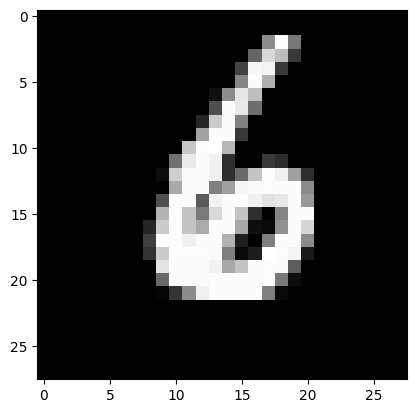

Prediction:  [1]
Label:  1


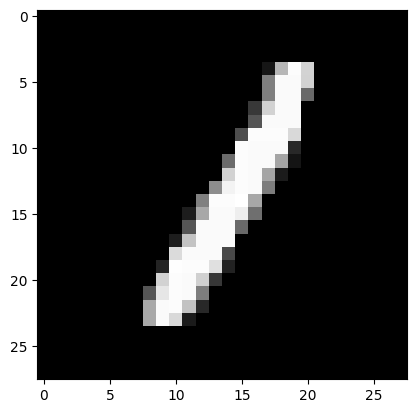

Prediction:  [0]
Label:  0


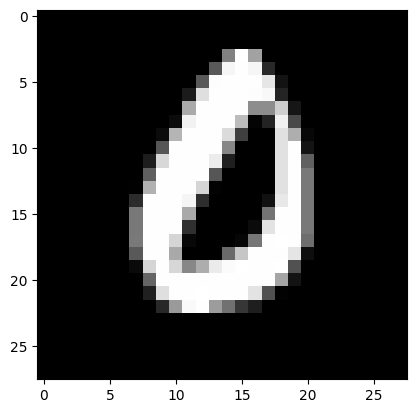

Prediction:  [1]
Label:  1


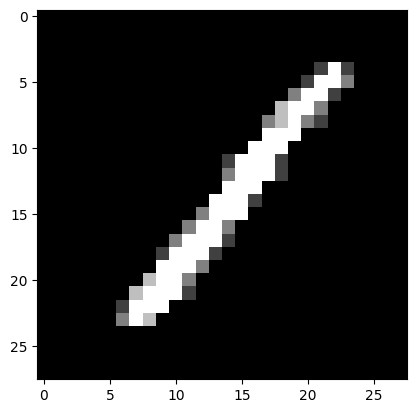

In [8]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

##### 6. Valutazione sul set di sviluppo (dev set)
Calcolo l'accuratezza della rete sul set di sviluppo per valutare la generalizzazione.

In [9]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[4 3 2 6 3 1 3 2 6 4 7 9 7 6 5 2 6 8 6 6 1 5 9 2 3 1 4 9 0 0 4 7 6 3 4 3 9
 5 7 1 7 6 1 8 1 2 6 9 4 8 9 6 5 8 1 4 8 8 6 4 1 8 4 8 9 0 5 2 2 8 6 0 3 1
 6 4 8 0 6 3 0 3 1 6 5 5 9 4 6 8 6 0 6 5 7 5 7 8 6 7 0 9 2 5 8 3 7 6 7 2 2
 1 3 5 8 3 4 7 5 8 8 6 4 5 7 5 2 8 1 6 4 6 8 0 3 6 1 8 9 3 7 7 7 9 7 7 3 0
 7 3 4 7 8 6 7 4 1 9 0 6 6 9 9 6 6 3 4 3 7 4 4 8 4 6 8 5 9 4 1 1 1 3 0 3 6
 9 7 9 1 1 3 1 1 5 0 9 2 1 0 0 4 3 2 7 2 3 8 1 8 2 1 5 1 4 6 6 1 1 6 1 3 6
 1 8 5 3 7 9 8 9 8 1 1 6 1 1 1 4 1 0 5 9 8 6 9 0 6 0 7 1 0 9 8 4 1 5 7 2 8
 6 6 0 8 0 2 9 1 1 8 4 1 5 2 5 0 1 7 3 9 1 2 1 6 6 1 0 6 1 3 1 7 3 8 6 2 0
 5 1 5 4 2 9 7 1 8 0 1 6 1 3 0 4 6 7 0 6 9 9 4 9 9 6 2 7 1 2 4 6 0 3 0 6 7
 7 2 2 7 4 7 4 1 1 7 4 0 2 4 0 8 3 9 2 8 1 7 6 3 5 0 0 2 9 7 2 6 1 1 2 6 0
 3 1 1 2 1 3 5 2 0 6 7 2 4 2 7 7 5 0 3 5 3 9 1 5 0 7 0 1 3 9 2 8 1 0 0 9 1
 5 5 2 7 6 7 9 4 2 9 9 7 8 1 8 2 3 0 6 7 0 9 8 5 8 7 8 0 9 3 8 2 1 6 2 0 9
 1 5 7 0 3 8 4 2 9 9 4 6 3 1 6 4 5 9 6 3 5 9 7 3 5 2 1 7 4 3 9 9 2 1 4 6 9
 1 3 9 7 2 1 6 4 4 4 1 2 

np.float64(0.837)

84% accuracy, posso dire che la rete ha generalizzato piuttosto bene i dati di training.

##### 7. Predizione sul test set e salvataggio risultati
Applico la rete ai dati di test e salvo le predizioni in un file CSV per la submission.

In [10]:
# Carica e normalizza il test set
test_data = pd.read_csv('test.csv')
X_test = np.array(test_data)
X_test = X_test / 255.  # Normalizza pixel

# Predizioni sul test set
_, _, _, A2_test = forward_prop(W1, b1, W2, b2, X_test.T)
test_predictions = get_predictions(A2_test)

# Crea il DataFrame per la submission
submission = pd.DataFrame({
    'ImageId': range(1, len(test_predictions) + 1),
    'Label': test_predictions
})

# Salva le predizioni su file CSV
submission.to_csv('Submission.csv', index=False)
print(f'Predictions saved to Submission.csv')
print(f'Number of test images: {len(test_predictions)}')
print('\nFirst few predictions:')
print(submission.head())

Predictions saved to Submission.csv
Number of test images: 28000

First few predictions:
   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      4
4        5      2


#### Schema della rete

- **Input:** 784 neuroni (pixel)
- **Hidden layer:** 10 neuroni, attivazione ReLU
- **Output layer:** 10 neuroni, attivazione softmax (classi 0-9)

Questa architettura semplice permette di classificare le cifre MNIST con una buona accuratezza, implementando tutto da zero senza librerie di deep learning avanzate.